In [1]:
# LOADING LIBRARIES
import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import HistGradientBoostingRegressor
import joblib
import matplotlib.pyplot as plt

In [2]:
auction_df = pd.read_excel('../data/auctiondata_w_brass_index.xlsx')

In [3]:
print(auction_df.columns.tolist())

['year_month_dt', 'product_group', 'proposed_rp', 'last_bid_price', 'brass_index_poly', 'ewm_last_bid_price', 'ewm_proposed_rp', 'quantity', 'h1_buyer_name']


In [4]:
auction_df['year_month_dt'] = pd.to_datetime(auction_df['year_month_dt'])
auction_df['year'] = auction_df['year_month_dt'].dt.year
auction_df['month'] = auction_df['year_month_dt'].dt.month

In [7]:
# DEFINING FEATURES
CYL_FEATURES = [
    'year', 'month', 'quantity', 
    'ewm_proposed_rp', 'ewm_last_bid_price',
    'day_of_week', 'day_of_month', 'week_of_year',
    'days_since_last_auction', 'auction_frequency_7d',
    'price_momentum_7d', 'price_momentum_30d',
    'quantity_trend_7d', 'quantity_trend_30d',
    'last_auction_price', 'last_auction_quantity',
    'price_volatility_7d', 'price_volatility_30d'
]
VALVES_FEATURES = CYL_FEATURES + [
    'brass_index_poly', 'brass_index_momentum_7d',
    'brass_index_momentum_30d', 'brass_index_volatility_7d'
]

TEMP_FEATURES = [
    'rolling_mean_7d_proposed_rp', 'rolling_mean_30d_proposed_rp',
    'rolling_mean_7d_last_bid_price', 'rolling_mean_30d_last_bid_price',
    'rolling_std_7d_proposed_rp', 'rolling_std_30d_proposed_rp',
    'rolling_std_7d_last_bid_price', 'rolling_std_30d_last_bid_price',
    'price_change_1d', 'price_change_7d', 'price_change_30d',
    'quantity_change_1d', 'quantity_change_7d', 'quantity_change_30d'
]


In [6]:
# SPLIT BY PRODUCT GROUP
cyl_df = auction_df[auction_df['product_group'] == 'cylinders'].dropna()
valve_df = auction_df[auction_df['product_group'] == 'valves'].dropna()

In [8]:
CYL_FEATURES_ENHANCED = CYL_FEATURES + TEMP_FEATURES
VALVES_FEATURES_ENHANCED = VALVES_FEATURES + TEMP_FEATURES

In [9]:


print("Enhanced feature definitions created:")
print(f"Cylinder features: {len(CYL_FEATURES_ENHANCED)} features")
print(f"Valve features: {len(VALVES_FEATURES_ENHANCED)} features")


Enhanced feature definitions created:
Cylinder features: 32 features
Valve features: 36 features


In [11]:
def calculate_dynamic_ewm_features(df, target_date, product_group='cylinders'):
    """
    Calculate EWM features dynamically for a specific date.
    
    Parameters:
    - df: Full dataset
    - target_date: Date for which to calculate EWM
    - product_group: 'cylinders' or 'valves'
    
    Returns:
    - ewm_proposed_rp: EWM value for proposed_rp up to target_date
    - ewm_last_bid_price: EWM value for last_bid_price up to target_date
    """
    
    # Filter data for the specific product group up to target_date
    if product_group == 'cylinders':
        cylinders = [x.lower().strip() for x in [
            '14.2 Kg', '19 Kg', '5 Kg', '47.5 Kg', '5 Kg FTLR', '5 Kg ND',
            '47.5 Kg LOTV', '19 Kg SC', '19 Kg NCut', '5 Kg FTL', '14.2 Kg OMC'
        ]]
        def map_product_type(desc):
            desc = str(desc).lower().strip()
            return 'cylinders' if desc in cylinders else 'other'
        
        if 'product_group' not in df.columns:
            df['product_group'] = df['productdescription'].apply(map_product_type)
        
        historical_data = df[
            (df['product_group'] == 'cylinders') &
            (df['auction_date'] < target_date)
        ].copy()
        
    elif product_group == 'valves':
        valves = [x.lower().strip() for x in ['SC Valve', 'LIQUID OFFTAKE VALVE']]
        def map_product_type(desc):
            desc = str(desc).lower().strip()
            return 'valves' if desc in valves else 'other'
        
        if 'product_group' not in df.columns:
            df['product_group'] = df['productdescription'].apply(map_product_type)
        
        historical_data = df[
            (df['product_group'] == 'valves') &
            (df['auction_date'] < target_date)
        ].copy()
    
    # Sort by date to ensure proper EWM calculation
    historical_data = historical_data.sort_values('auction_date')
    
    # Calculate EWM values (using alpha=0.1 for smoothing)
    if len(historical_data) > 0:
        ewm_proposed_rp = historical_data['proposed_rp'].ewm(alpha=0.1).mean().iloc[-1]
        ewm_last_bid_price = historical_data['last_bid_price'].ewm(alpha=0.1).mean().iloc[-1]
    else:
        # Fallback values if no historical data
        if product_group == 'cylinders':
            ewm_proposed_rp = 35000
            ewm_last_bid_price = 34000
        else:  # valves
            ewm_proposed_rp = 45000
            ewm_last_bid_price = 43000
    
    return ewm_proposed_rp, ewm_last_bid_price

In [12]:
def add_temporal_features(df, product_group='cylinders'):
    """
    Add comprehensive temporal features to the dataset.
    
    Parameters:
    - df: DataFrame with auction data
    - product_group: 'cylinders' or 'valves'
    
    Returns:
    - df: DataFrame with added temporal features
    """
    
    # Sort by date for proper temporal calculations
    df = df.sort_values('auction_date').copy()
    
    # Basic temporal features
    df['day_of_week'] = df['auction_date'].dt.dayofweek
    df['day_of_month'] = df['auction_date'].dt.day
    df['week_of_year'] = df['auction_date'].dt.isocalendar().week
    
    # Filter for specific product group
    if product_group == 'cylinders':
        cylinders = [x.lower().strip() for x in [
            '14.2 Kg', '19 Kg', '5 Kg', '47.5 Kg', '5 Kg FTLR', '5 Kg ND',
            '47.5 Kg LOTV', '19 Kg SC', '19 Kg NCut', '5 Kg FTL', '14.2 Kg OMC'
        ]]
        def map_product_type(desc):
            desc = str(desc).lower().strip()
            return 'cylinders' if desc in cylinders else 'other'
        
        if 'product_group' not in df.columns:
            df['product_group'] = df['productdescription'].apply(map_product_type)
        
        product_data = df[df['product_group'] == 'cylinders'].copy()
        
    elif product_group == 'valves':
        valves = [x.lower().strip() for x in ['SC Valve', 'LIQUID OFFTAKE VALVE']]
        def map_product_type(desc):
            desc = str(desc).lower().strip()
            return 'valves' if desc in valves else 'other'
        
        if 'product_group' not in df.columns:
            df['product_group'] = df['productdescription'].apply(map_product_type)
        
        product_data = df[df['product_group'] == 'valves'].copy()
    
    # Calculate days since last auction
    product_data['days_since_last_auction'] = product_data['auction_date'].diff().dt.days
    
    # Auction frequency (auctions in last 7 days)
    product_data['auction_frequency_7d'] = product_data['auction_date'].rolling(
        window=7, min_periods=1
    ).count()
    
    # Price momentum (rate of change)
    product_data['price_momentum_7d'] = product_data['proposed_rp'].pct_change(periods=7)
    product_data['price_momentum_30d'] = product_data['proposed_rp'].pct_change(periods=30)
    
    # Quantity trends
    product_data['quantity_trend_7d'] = product_data['quantity'].pct_change(periods=7)
    product_data['quantity_trend_30d'] = product_data['quantity'].pct_change(periods=30)
    
    # Last auction values
    product_data['last_auction_price'] = product_data['proposed_rp'].shift(1)
    product_data['last_auction_quantity'] = product_data['quantity'].shift(1)
    
    # Price volatility
    product_data['price_volatility_7d'] = product_data['proposed_rp'].rolling(
        window=7, min_periods=1
    ).std()
    product_data['price_volatility_30d'] = product_data['proposed_rp'].rolling(
        window=30, min_periods=1
    ).std()
    
    # Rolling statistics
    product_data['rolling_mean_7d_proposed_rp'] = product_data['proposed_rp'].rolling(
        window=7, min_periods=1
    ).mean()
    product_data['rolling_mean_30d_proposed_rp'] = product_data['proposed_rp'].rolling(
        window=30, min_periods=1
    ).mean()
    
    product_data['rolling_mean_7d_last_bid_price'] = product_data['last_bid_price'].rolling(
        window=7, min_periods=1
    ).mean()
    product_data['rolling_mean_30d_last_bid_price'] = product_data['last_bid_price'].rolling(
        window=30, min_periods=1
    ).mean()
    
    # Price changes
    product_data['price_change_1d'] = product_data['proposed_rp'].pct_change(periods=1)
    product_data['price_change_7d'] = product_data['proposed_rp'].pct_change(periods=7)
    product_data['price_change_30d'] = product_data['proposed_rp'].pct_change(periods=30)
    
    # Quantity changes
    product_data['quantity_change_1d'] = product_data['quantity'].pct_change(periods=1)
    product_data['quantity_change_7d'] = product_data['quantity'].pct_change(periods=7)
    product_data['quantity_change_30d'] = product_data['quantity'].pct_change(periods=30)
    
    # Add brass index features for valves
    if product_group == 'valves' and 'brass_index_poly' in product_data.columns:
        product_data['brass_index_momentum_7d'] = product_data['brass_index_poly'].pct_change(periods=7)
        product_data['brass_index_momentum_30d'] = product_data['brass_index_poly'].pct_change(periods=30)
        product_data['brass_index_volatility_7d'] = product_data['brass_index_poly'].rolling(
            window=7, min_periods=1
        ).std()
    
    # Fill NaN values with appropriate defaults
    numeric_columns = product_data.select_dtypes(include=[np.number]).columns
    for col in numeric_columns:
        if col in product_data.columns:
            product_data[col] = product_data[col].fillna(method='ffill').fillna(0)
    
    return product_data

In [13]:
print("Using enhanced temporal features for model training")
print(f"Cylinder features: {CYL_FEATURES_ENHANCED}")
print(f"Valve features: {VALVES_FEATURES_ENHANCED}")

Using enhanced temporal features for model training
Cylinder features: ['year', 'month', 'quantity', 'ewm_proposed_rp', 'ewm_last_bid_price', 'day_of_week', 'day_of_month', 'week_of_year', 'days_since_last_auction', 'auction_frequency_7d', 'price_momentum_7d', 'price_momentum_30d', 'quantity_trend_7d', 'quantity_trend_30d', 'last_auction_price', 'last_auction_quantity', 'price_volatility_7d', 'price_volatility_30d', 'rolling_mean_7d_proposed_rp', 'rolling_mean_30d_proposed_rp', 'rolling_mean_7d_last_bid_price', 'rolling_mean_30d_last_bid_price', 'rolling_std_7d_proposed_rp', 'rolling_std_30d_proposed_rp', 'rolling_std_7d_last_bid_price', 'rolling_std_30d_last_bid_price', 'price_change_1d', 'price_change_7d', 'price_change_30d', 'quantity_change_1d', 'quantity_change_7d', 'quantity_change_30d']
Valve features: ['year', 'month', 'quantity', 'ewm_proposed_rp', 'ewm_last_bid_price', 'day_of_week', 'day_of_month', 'week_of_year', 'days_since_last_auction', 'auction_frequency_7d', 'price_mom

In [7]:
# SPLITTING CHRONOLOGICALLY
def time_split(df, date_col, test_frac=0.2):
    df = df.sort_values(date_col)
    split_idx = int(len(df) * (1 - test_frac))
    return df.iloc[:split_idx], df.iloc[split_idx:]

cyl_train, cyl_test = time_split(cyl_df, 'year_month_dt')
valve_train, valve_test = time_split(valve_df, 'year_month_dt')

In [8]:
def make_preprocessor(features, train_df, save_path):
    preprocessor = ColumnTransformer([
        ('num', StandardScaler(), features)
    ])
    preprocessor.fit(train_df[features])
    joblib.dump(preprocessor, save_path)
    print(f"Saved preprocessor to: {save_path}")
    return preprocessor

In [9]:
cyl_preproc = make_preprocessor(
    CYL_FEATURES, cyl_train, 
    '../models/cyl_preproc.joblib'
)
valve_preproc = make_preprocessor(
    VALVES_FEATURES, valve_train, 
    '../models/valve_preproc.joblib'
)

Saved preprocessor to: ../models/cyl_preproc.joblib
Saved preprocessor to: ../models/valve_preproc.joblib


In [10]:
def fit_and_save_quantile_regressors(X, y, model_prefix):
    base_dir = '../models'
    for q in [0.25, 0.5, 0.75]:
        model = HistGradientBoostingRegressor(loss='quantile', quantile=q, random_state=42)
        model.fit(X, y)
        save_path = f"{base_dir}/{model_prefix}_q{int(q*100)}.joblib"
        joblib.dump(model, save_path)
        print(f"Saved model to: {save_path}")

# Prepare training data
X_cyl = cyl_preproc.transform(cyl_train[CYL_FEATURES])

# Train and save for proposed_rp
y_cyl_rp = cyl_train['proposed_rp']
fit_and_save_quantile_regressors(X_cyl, y_cyl_rp, 'cyl_rp')

# Train and save for last_bid_price
y_cyl_lbp = cyl_train['last_bid_price']
fit_and_save_quantile_regressors(X_cyl, y_cyl_lbp, 'cyl_lbp')

Saved model to: ../models/cyl_rp_q25.joblib
Saved model to: ../models/cyl_rp_q50.joblib
Saved model to: ../models/cyl_rp_q75.joblib
Saved model to: ../models/cyl_lbp_q25.joblib
Saved model to: ../models/cyl_lbp_q50.joblib
Saved model to: ../models/cyl_lbp_q75.joblib


In [11]:
X_valve = valve_preproc.transform(valve_train[VALVES_FEATURES])

# Train and save for proposed_rp
y_valve_rp = valve_train['proposed_rp']
fit_and_save_quantile_regressors(X_valve, y_valve_rp, 'valve_rp')

# Train and save for last_bid_price
y_valve_lbp = valve_train['last_bid_price']
fit_and_save_quantile_regressors(X_valve, y_valve_lbp, 'valve_lbp')

Saved model to: ../models/valve_rp_q25.joblib
Saved model to: ../models/valve_rp_q50.joblib
Saved model to: ../models/valve_rp_q75.joblib
Saved model to: ../models/valve_lbp_q25.joblib
Saved model to: ../models/valve_lbp_q50.joblib
Saved model to: ../models/valve_lbp_q75.joblib


In [12]:
X_test_cyl = cyl_preproc.transform(cyl_test[CYL_FEATURES])
y_test_cyl_rp = cyl_test['proposed_rp'].values 

In [13]:
# LOAD MODELS
cyl_rp_model_25 = joblib.load('../models/cyl_rp_q25.joblib')
cyl_rp_model_50 = joblib.load('../models/cyl_rp_q50.joblib')
cyl_rp_model_75 = joblib.load('../models/cyl_rp_q75.joblib')

# PREDICT QUANTILES
y_pred_cyl_25 = cyl_rp_model_25.predict(X_test_cyl)
y_pred_cyl_50 = cyl_rp_model_50.predict(X_test_cyl)
y_pred_cyl_75 = cyl_rp_model_75.predict(X_test_cyl)

In [14]:
# BUILD RESULTS DATAFRAME
results_df_cyl_rp = pd.DataFrame({
    'actual': y_test_cyl_rp,
    'pred_lower': y_pred_cyl_25,
    'pred_median': y_pred_cyl_50,
    'pred_upper': y_pred_cyl_75
})

# CALCULATE ERRORS
results_df_cyl_rp['abs_error'] = (results_df_cyl_rp['actual'] - results_df_cyl_rp['pred_median']).abs()
results_df_cyl_rp['pct_error'] = results_df_cyl_rp['abs_error'] / results_df_cyl_rp['actual'] * 100

In [15]:
# CYLINDERS — Last Bid Price
X_test_cyl_lbp = cyl_preproc.transform(cyl_test[CYL_FEATURES])
y_test_cyl_lbp = cyl_test['last_bid_price'].values

cyl_lbp_model_25 = joblib.load('../models/cyl_lbp_q25.joblib')
cyl_lbp_model_50 = joblib.load('../models/cyl_lbp_q50.joblib')
cyl_lbp_model_75 = joblib.load('../models/cyl_lbp_q75.joblib')

y_pred_cyl_lbp_25 = cyl_lbp_model_25.predict(X_test_cyl_lbp)
y_pred_cyl_lbp_50 = cyl_lbp_model_50.predict(X_test_cyl_lbp)
y_pred_cyl_lbp_75 = cyl_lbp_model_75.predict(X_test_cyl_lbp)

results_df_cyl_lbp = pd.DataFrame({
    'actual': y_test_cyl_lbp,
    'pred_lower': y_pred_cyl_lbp_25,
    'pred_median': y_pred_cyl_lbp_50,
    'pred_upper': y_pred_cyl_lbp_75
})
results_df_cyl_lbp['abs_error'] = (results_df_cyl_lbp['actual'] - results_df_cyl_lbp['pred_median']).abs()
results_df_cyl_lbp['pct_error'] = results_df_cyl_lbp['abs_error'] / results_df_cyl_lbp['actual'] * 100
results_df_cyl_lbp = results_df_cyl_lbp.round(2)
print(results_df_cyl_lbp.head())

   actual  pred_lower  pred_median  pred_upper  abs_error  pct_error
0   33600    31272.68     31941.28    32878.23    1658.72       4.94
1   33000    33728.29     34480.57    34700.54    1480.57       4.49
2   32900    33522.54     34382.43    34667.80    1482.43       4.51
3   34000    32657.13     33132.89    33411.87     867.11       2.55
4   34000    33165.47     33739.05    33604.29     260.95       0.77


In [16]:
# VALVES — Proposed RP
X_test_valve_rp = valve_preproc.transform(valve_test[VALVES_FEATURES])
y_test_valve_rp = valve_test['proposed_rp'].values

valve_rp_model_25 = joblib.load('../models/valve_rp_q25.joblib')
valve_rp_model_50 = joblib.load('../models/valve_rp_q50.joblib')
valve_rp_model_75 = joblib.load('../models/valve_rp_q75.joblib')

y_pred_valve_rp_25 = valve_rp_model_25.predict(X_test_valve_rp)
y_pred_valve_rp_50 = valve_rp_model_50.predict(X_test_valve_rp)
y_pred_valve_rp_75 = valve_rp_model_75.predict(X_test_valve_rp)

results_df_valve_rp = pd.DataFrame({
    'actual': y_test_valve_rp,
    'pred_lower': y_pred_valve_rp_25,
    'pred_median': y_pred_valve_rp_50,
    'pred_upper': y_pred_valve_rp_75
})
results_df_valve_rp['abs_error'] = (results_df_valve_rp['actual'] - results_df_valve_rp['pred_median']).abs()
results_df_valve_rp['pct_error'] = results_df_valve_rp['abs_error'] / results_df_valve_rp['actual'] * 100
results_df_valve_rp = results_df_valve_rp.round(2)
print(results_df_valve_rp.head())

      actual  pred_lower  pred_median  pred_upper  abs_error  pct_error
0  503666.67   506914.60    515540.76   519097.36   11874.09       2.36
1  508333.33   514530.93    517186.76   518664.05    8853.43       1.74
2  521000.00   519212.38    526861.79   518012.53    5861.79       1.13
3  554000.00   515265.06    526915.44   526649.25   27084.56       4.89
4  506666.67   491086.19    491215.47   486440.22   15451.20       3.05


In [17]:
# PREPARE TEST DATA FOR VALVES (last_bid_price)
X_test_valve = valve_preproc.transform(valve_test[VALVES_FEATURES])
y_test_valve_lbp = valve_test['last_bid_price'].values

# LOAD MODELS
valve_lbp_model_25 = joblib.load('../models/valve_lbp_q25.joblib')
valve_lbp_model_50 = joblib.load('../models/valve_lbp_q50.joblib')
valve_lbp_model_75 = joblib.load('../models/valve_lbp_q75.joblib')

# PREDICT QUANTILES
y_pred_valve_25 = valve_lbp_model_25.predict(X_test_valve)
y_pred_valve_50 = valve_lbp_model_50.predict(X_test_valve)
y_pred_valve_75 = valve_lbp_model_75.predict(X_test_valve)

# BUILD RESULTS DATAFRAME
results_df_valve_lbp = pd.DataFrame({
    'actual': y_test_valve_lbp,
    'pred_lower': y_pred_valve_25,
    'pred_median': y_pred_valve_50,
    'pred_upper': y_pred_valve_75
})

# CALCULATE ERRORS
results_df_valve_lbp['abs_error'] = (results_df_valve_lbp['actual'] - results_df_valve_lbp['pred_median']).abs()
results_df_valve_lbp['pct_error'] = results_df_valve_lbp['abs_error'] / results_df_valve_lbp['actual'] * 100

# Optionally round for display


In [18]:
results_df_valve_lbp = results_df_valve_lbp.round(2)

print(results_df_valve_lbp.head())

   actual  pred_lower  pred_median  pred_upper  abs_error  pct_error
0  496000   503446.40    503771.79   506514.84    7771.79       1.57
1  507000   523353.48    521369.83   520733.72   14369.83       2.83
2  511000   482417.06    514511.02   516911.34    3511.02       0.69
3  512000   481634.16    519562.56   521233.59    7562.56       1.48
4  501000   486105.13    521137.03   527009.54   20137.03       4.02


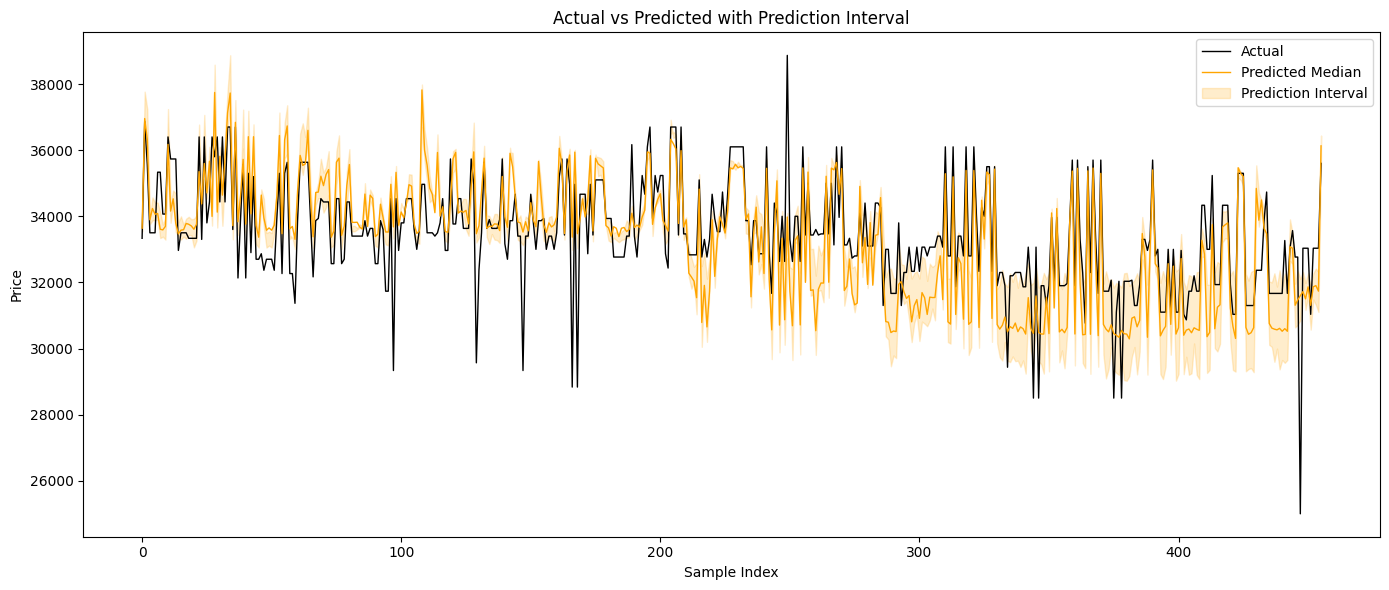

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
plt.plot(results_df_cyl_rp['actual'], label='Actual', color='black', linewidth=1, linestyle='-')
plt.plot(results_df_cyl_rp['pred_median'], label='Predicted Median', color='orange', linewidth=1)
plt.fill_between(results_df_cyl_rp.index, results_df_cyl_rp['pred_lower'], results_df_cyl_rp['pred_upper'], color='orange', alpha=0.2, label='Prediction Interval')
plt.legend()
plt.xlabel('Sample Index')
plt.ylabel('Price')
plt.title('Actual vs Predicted with Prediction Interval')
plt.tight_layout()
plt.show()

In [20]:
def print_sample_predictions(df, title="SAMPLE PREDICTIONS"):
    print("="*80)
    print(f"{title}")
    print("="*80)
    header = (
        f"{'Actual Price':>13}  {'Predicted Price':>15}  {'Prediction Error':>17}  {'Error %':>8}  "
        f"{'Lower Bound (Q25)':>18}  {'Upper Bound (Q75)':>18}  {'In Range':>10}"
    )
    print(header)
    for idx, row in df.iterrows():
        lower = min(row['pred_lower'], row['pred_upper'])
        upper = max(row['pred_lower'], row['pred_upper'])
        in_range = lower <= row['actual'] <= upper
        print(
            f"{row['actual']:13,.2f}  "
            f"{row['pred_median']:15,.2f}  "
            f"{row['abs_error']:17,.2f}  "
            f"{row['pct_error']:8.2f}  "
            f"{row['pred_lower']:18,.2f}  "
            f"{row['pred_upper']:18,.2f}  "
            f"{'Yes' if in_range else 'No':>10}"
        )
    print("="*80)

In [21]:
print_sample_predictions(results_df_cyl_rp.head(10), title="SAMPLE PREDICTIONS")

SAMPLE PREDICTIONS
 Actual Price  Predicted Price   Prediction Error   Error %   Lower Bound (Q25)   Upper Bound (Q75)    In Range
    33,333.33        33,639.37             306.04      0.92           33,537.01           33,855.99          No
    36,866.67        36,956.57              89.90      0.24           36,289.44           37,769.64         Yes
    35,566.67        36,325.85             759.18      2.13           36,235.33           37,236.96          No
    33,500.00        33,893.39             393.39      1.17           33,756.38           33,988.51          No
    33,500.00        34,236.26             736.26      2.20           33,876.52           34,570.04          No
    33,500.00        34,061.43             561.43      1.68           33,889.61           34,414.28          No
    35,333.33        34,084.50           1,248.83      3.53           33,889.61           34,414.75          No
    35,333.33        33,606.46           1,726.87      4.89           33,340.15      

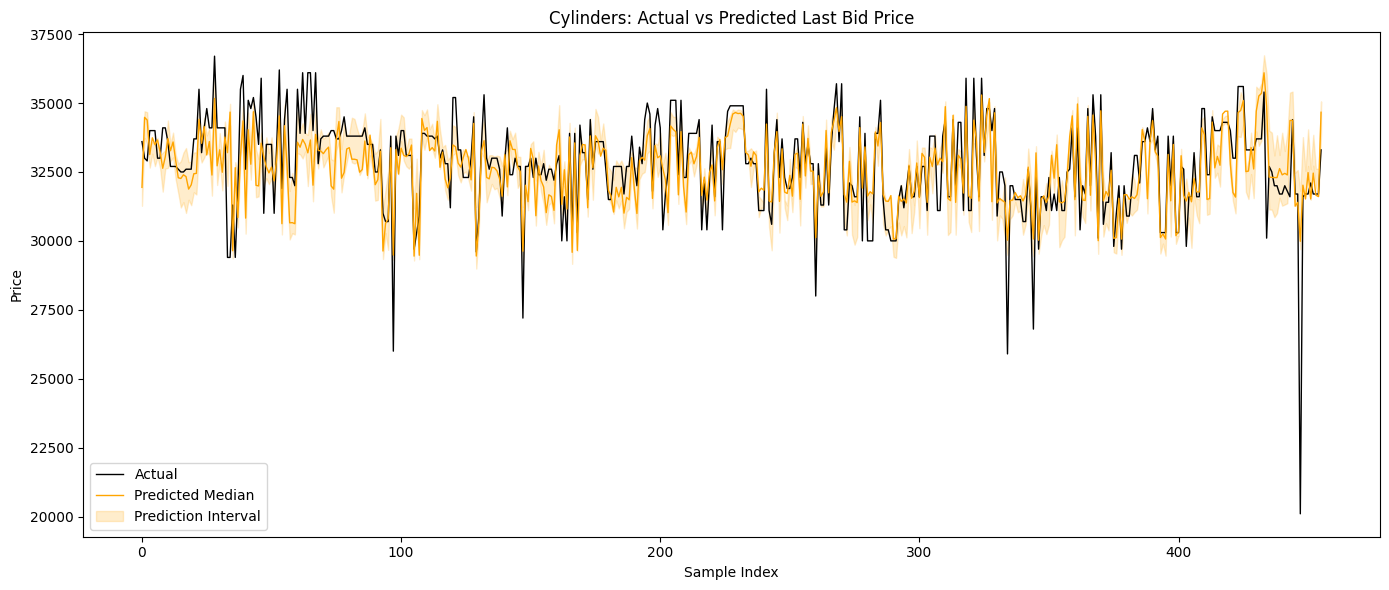

In [22]:
plt.figure(figsize=(14, 6))
plt.plot(results_df_cyl_lbp['actual'], label='Actual', color='black', linewidth=1, linestyle='-')
plt.plot(results_df_cyl_lbp['pred_median'], label='Predicted Median', color='orange', linewidth=1)
plt.fill_between(results_df_cyl_lbp.index, results_df_cyl_lbp['pred_lower'], results_df_cyl_lbp['pred_upper'], color='orange', alpha=0.2, label='Prediction Interval')
plt.legend()
plt.xlabel('Sample Index')
plt.ylabel('Price')
plt.title('Cylinders: Actual vs Predicted Last Bid Price')
plt.tight_layout()
plt.show()

In [23]:
print_sample_predictions(results_df_cyl_lbp.head(10), title="SAMPLE PREDICTIONS")

SAMPLE PREDICTIONS
 Actual Price  Predicted Price   Prediction Error   Error %   Lower Bound (Q25)   Upper Bound (Q75)    In Range
    33,600.00        31,941.28           1,658.72      4.94           31,272.68           32,878.23          No
    33,000.00        34,480.57           1,480.57      4.49           33,728.29           34,700.54          No
    32,900.00        34,382.43           1,482.43      4.51           33,522.54           34,667.80          No
    34,000.00        33,132.89             867.11      2.55           32,657.13           33,411.87          No
    34,000.00        33,739.05             260.95      0.77           33,165.47           33,604.29          No
    34,000.00        33,492.71             507.29      1.49           32,711.69           33,468.72          No
    33,000.00        33,656.06             656.06      1.99           33,044.09           33,733.85          No
    33,000.00        33,225.31             225.31      0.68           32,633.96      

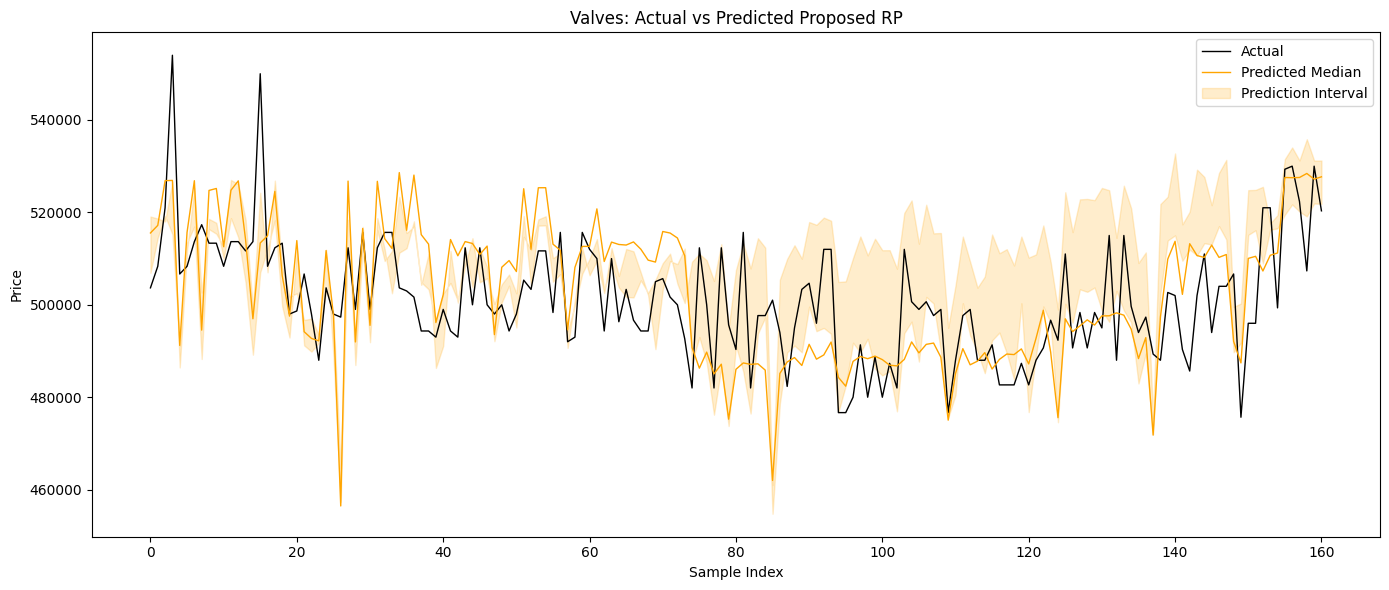

In [24]:
plt.figure(figsize=(14, 6))
plt.plot(results_df_valve_rp['actual'], label='Actual', color='black', linewidth=1, linestyle='-')
plt.plot(results_df_valve_rp['pred_median'], label='Predicted Median', color='orange', linewidth=1)
plt.fill_between(results_df_valve_rp.index, results_df_valve_rp['pred_lower'], results_df_valve_rp['pred_upper'], color='orange', alpha=0.2, label='Prediction Interval')
plt.legend()
plt.xlabel('Sample Index')
plt.ylabel('Price')
plt.title('Valves: Actual vs Predicted Proposed RP')
plt.tight_layout()
plt.show()

In [25]:
print_sample_predictions(results_df_valve_rp.head(10), title="SAMPLE PREDICTIONS - VALVE LBP")

SAMPLE PREDICTIONS - VALVE LBP
 Actual Price  Predicted Price   Prediction Error   Error %   Lower Bound (Q25)   Upper Bound (Q75)    In Range
   503,666.67       515,540.76          11,874.09      2.36          506,914.60          519,097.36          No
   508,333.33       517,186.76           8,853.43      1.74          514,530.93          518,664.05          No
   521,000.00       526,861.79           5,861.79      1.13          519,212.38          518,012.53          No
   554,000.00       526,915.44          27,084.56      4.89          515,265.06          526,649.25          No
   506,666.67       491,215.47          15,451.20      3.05          491,086.19          486,440.22          No
   508,333.33       515,678.37           7,345.04      1.44          513,451.33          511,688.65          No
   513,666.67       526,850.61          13,183.94      2.57          516,956.43          525,230.28          No
   517,333.33       494,521.27          22,812.06      4.41          488,

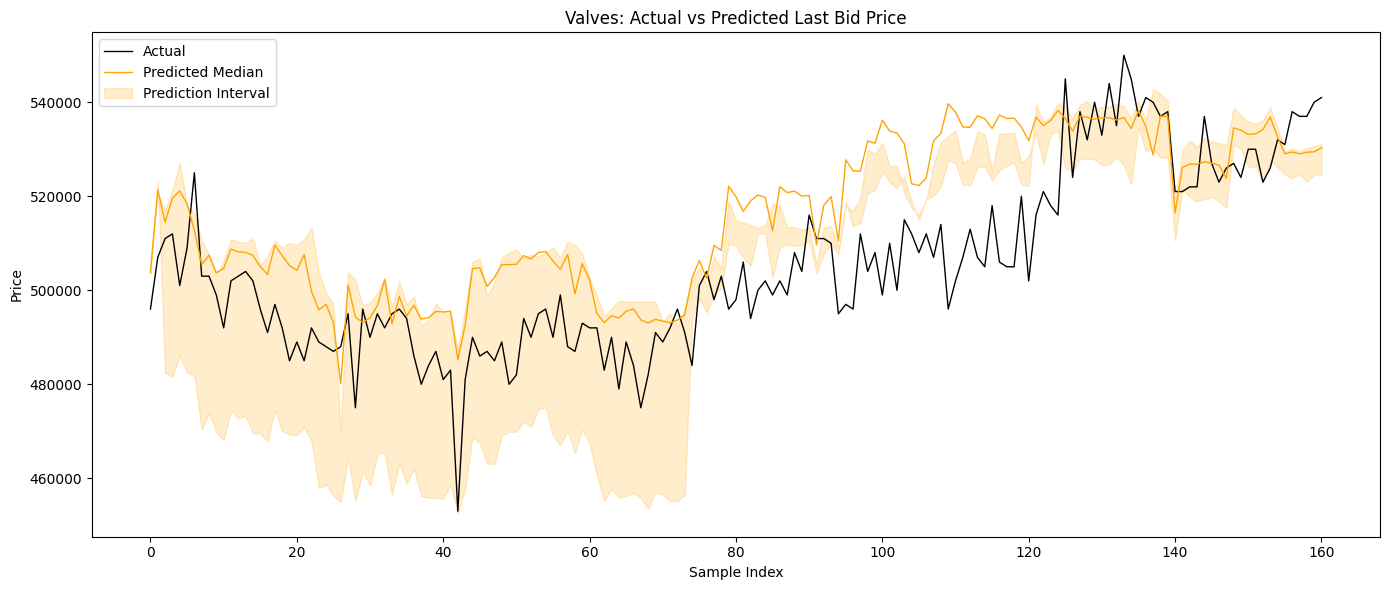

In [26]:
plt.figure(figsize=(14, 6))
plt.plot(results_df_valve_lbp['actual'], label='Actual', color='black', linewidth=1, linestyle='-')
plt.plot(results_df_valve_lbp['pred_median'], label='Predicted Median', color='orange', linewidth=1)
plt.fill_between(results_df_valve_lbp.index, results_df_valve_lbp['pred_lower'], results_df_valve_lbp['pred_upper'], color='orange', alpha=0.2, label='Prediction Interval')
plt.legend()
plt.xlabel('Sample Index')
plt.ylabel('Price')
plt.title('Valves: Actual vs Predicted Last Bid Price')
plt.tight_layout()
plt.show()

In [27]:
print_sample_predictions(results_df_valve_lbp.head(10), title="SAMPLE PREDICTIONS - VALVE LBP")

SAMPLE PREDICTIONS - VALVE LBP
 Actual Price  Predicted Price   Prediction Error   Error %   Lower Bound (Q25)   Upper Bound (Q75)    In Range
   496,000.00       503,771.79           7,771.79      1.57          503,446.40          506,514.84          No
   507,000.00       521,369.83          14,369.83      2.83          523,353.48          520,733.72          No
   511,000.00       514,511.02           3,511.02      0.69          482,417.06          516,911.34         Yes
   512,000.00       519,562.56           7,562.56      1.48          481,634.16          521,233.59         Yes
   501,000.00       521,137.03          20,137.03      4.02          486,105.13          527,009.54         Yes
   509,000.00       518,413.82           9,413.82      1.85          482,561.89          517,876.48         Yes
   525,000.00       512,760.65          12,239.35      2.33          481,748.36          516,526.65          No
   503,000.00       505,411.64           2,411.64      0.48          470,

In [28]:
print_sample_predictions(results_df_valve_lbp.tail(10), title="SAMPLE PREDICTIONS - VALVE LBP")

SAMPLE PREDICTIONS - VALVE LBP
 Actual Price  Predicted Price   Prediction Error   Error %   Lower Bound (Q25)   Upper Bound (Q75)    In Range
   530,000.00       533,270.23           3,270.23      0.62          526,409.06          535,465.62         Yes
   523,000.00       534,173.18          11,173.18      2.14          522,749.28          536,142.16         Yes
   526,000.00       536,877.56          10,877.56      2.07          527,550.36          538,845.59          No
   532,000.00       532,658.18             658.18      0.12          526,257.57          534,513.61         Yes
   531,000.00       529,049.63           1,950.37      0.37          524,662.21          529,491.25          No
   538,000.00       529,408.92           8,591.08      1.60          523,812.13          530,122.69          No
   537,000.00       529,022.04           7,977.96      1.49          524,614.56          529,491.25          No
   537,000.00       529,375.24           7,624.76      1.42          523,

## FINETUNING MODEL

In [29]:
ft_df = auction_df.copy()

In [30]:
ft_df['rp_per_qty'] = ft_df['proposed_rp'] / ft_df['quantity']
ft_df['total_amt'] = ft_df['last_bid_price'] * ft_df['quantity']  
ft_df['amt_per_qty'] = ft_df['total_amt'] / ft_df['quantity']
# ft_df['plant_freq'] = ft_df.groupby('plant_id')['proposed_rp'].transform('count')
# ft_df['state_freq'] = ft_df.groupby('state')['proposed_rp'].transform('count')
ft_df['proposed_rp_clipped'] = ft_df['proposed_rp'].clip(lower=0, upper=1000000)
ft_df['quantity_clipped'] = ft_df['quantity'].clip(lower=0, upper=1000000)
ft_df['last_bid_price_clipped'] = ft_df['last_bid_price'].clip(lower=0, upper=1000000)
ft_df['ft_rp_per_qty'] = ft_df['rp_per_qty'].clip(lower=0, upper=1000000)
ft_df['ft_amt_per_qty'] = ft_df['amt_per_qty'].clip(lower=0, upper=1000000)
# ft_df['ft_plant_freq'] = ft_df['plant_freq'].clip(lower=0, upper=1000000)
# ft_df['ft_state_freq'] = ft_df['state_freq'].clip(lower=0, upper=1000000)
ft_df['ft_proposed_rp_clipped'] = ft_df['proposed_rp_clipped'].clip(lower=0, upper=1000000)

In [31]:
# # 2. Select Features for Modeling
# ft_features = [
#     'month', 'year',
#     'rp_per_qty', 'amt_per_qty',
#     'proposed_rp_clipped', 'quantity_clipped', 'last_bid_price_clipped'
# ]
# ft_target = 'last_bid_price'

In [47]:
# 4. Quantile Regression with LightGBM ()
import lightgbm as lgb

def fit_lgb_quantile(X, y, quantile):
    params = {
        'objective': 'quantile',
        'alpha': quantile,
        'learning_rate': 0.05,
        'n_estimators': 200,
        'max_depth': 5,
        'min_child_samples': 10,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'random_state': 42,
        'verbose': -1
    }
    model = lgb.LGBMRegressor(**params)
    model.fit(X, y)
    return model


In [ ]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split

def train_and_report_quantile_model(
    df, features, target, title="SAMPLE PREDICTIONS", test_size=0.2, random_state=42
): 
    data_with_target = X.copy()
    data_with_target['target'] = y
    data_with_target['date'] = df['auction_date']
    # Split data
    X_train = train_data.drop(['target', 'date'], axis=1)
    X_test = test_data.drop(['target', 'date'], axis=1)
    y_train = train_data['target']
    y_test = test_data['target']
    # Quantile model trainer
    def fit_lgb_quantile(X, y, quantile):
        params = {
            'objective': 'quantile',
            'alpha': quantile,
            'learning_rate': 0.05,
            'n_estimators': 200,
            'max_depth': 5,
            'min_child_samples': 10,
            'subsample': 0.8,
            'colsample_bytree': 0.8,
            'random_state': 42,
            'verbose': -1
        }
        model = lgb.LGBMRegressor(**params)
        model.fit(X, y)
        return model

In [50]:

def print_ft_sample_predictions(df, title="SAMPLE PREDICTIONS"):
    print("="*80)
    print(f"{title}")
    print("="*80)
    header = (
        f"{'Actual Price':>13}  {'Predicted Price':>15}  {'Prediction Error':>17}  {'Error %':>8}  "
        f"{'Lower Bound (Q25)':>18}  {'Upper Bound (Q75)':>18}  {'In Range':>10}"
    )
    print(header)
    for idx, row in df.head(10).iterrows():
        lower = min(row['pred_q25'], row['pred_q75'])
        upper = max(row['pred_q25'], row['pred_q75'])
        in_range = lower <= row['actual'] <= upper
        print(
            f"{row['actual']:13,.2f}  "
            f"{row['pred_q50']:15,.2f}  "
            f"{row['abs_error']:17,.2f}  "
            f"{row['pct_error']:8.2f}  "
            f"{row['pred_q25']:18,.2f}  "
            f"{row['pred_q75']:18,.2f}  "
            f"{'Yes' if in_range else 'No':>10}"
        )
    print("="*80)

import matplotlib.pyplot as plt

def plot_predictions(results, title="Actual vs Predicted (Median) with Prediction Interval"):
    plt.figure(figsize=(14, 6))
    plt.plot(results['actual'].values, label='Actual', color='black', linewidth=1, linestyle='-')
    plt.plot(results['pred_q50'].values, label='Predicted Median', color='orange', linewidth=1)
    plt.fill_between(
        range(len(results)),
        results['pred_q25'].values,
        results['pred_q75'].values,
        color='orange', alpha=0.2, label='Prediction Interval (Q25-Q75)'
    )
    # Add median line for actual values
    plt.axhline(results['actual'].median(), color='blue', linestyle='--', linewidth=1, label='Actual Median')
    plt.legend()
    plt.xlabel('Sample Index')
    plt.ylabel('Price')
    plt.title(title)
    plt.tight_layout()
    plt.show()


SAMPLE PREDICTIONS - CYLINDERS: PROPOSED RP
 Actual Price  Predicted Price   Prediction Error   Error %   Lower Bound (Q25)   Upper Bound (Q75)    In Range
    38,633.33        39,779.70           1,146.37      2.97           39,151.78           39,747.60          No
    43,466.67        42,468.22             998.45      2.30           40,954.58           43,705.38         Yes
    33,133.33        36,781.91           3,648.58     11.01           35,163.81           37,488.98          No
    33,166.67        33,461.29             294.62      0.89           33,177.78           34,488.03          No
    33,866.67        33,945.90              79.23      0.23           33,538.16           35,256.83         Yes
    36,900.00        35,182.00           1,718.00      4.66           34,025.70           35,968.92          No
    41,833.33        43,732.91           1,899.58      4.54           41,667.50           46,406.83         Yes
    39,166.67        39,807.37             640.70      1.64 

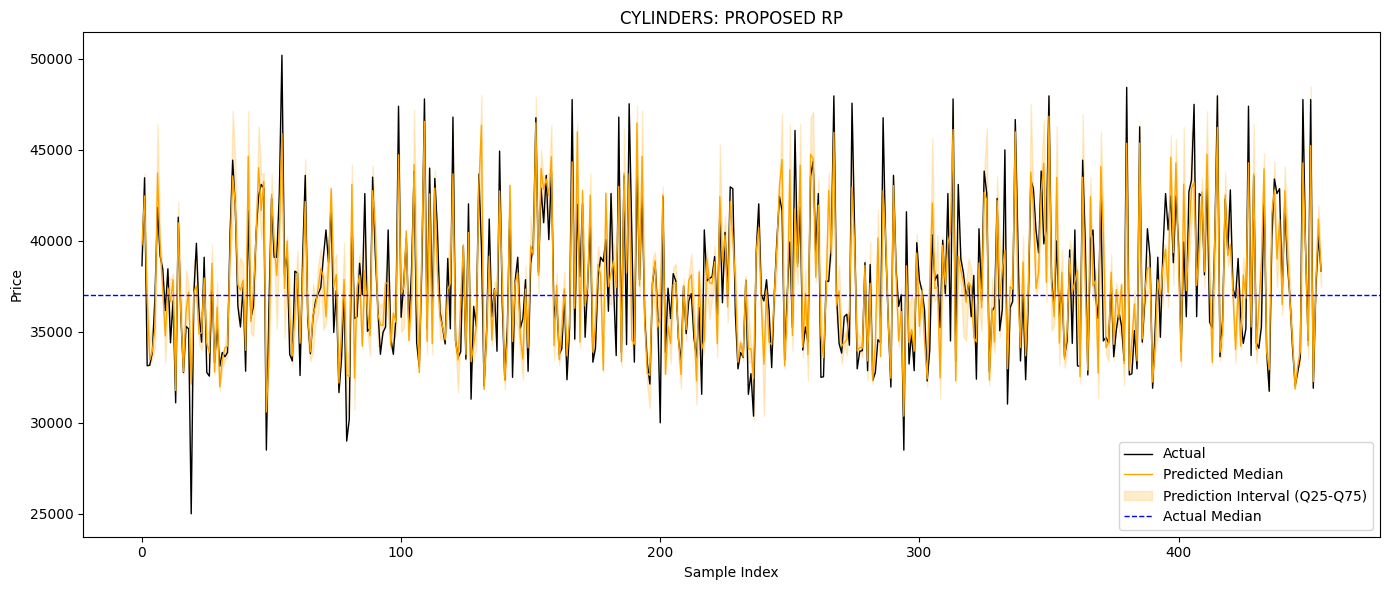

In [ ]:
# 1. Prepare data for cylinders
cyl_df = auction_df[auction_df['product_group'] == 'cylinders'].dropna().copy()
cyl_df['amt_per_qty'] = cyl_df['last_bid_price']  # This is fine as it does not use proposed_rp
cyl_df['quantity_clipped'] = cyl_df['quantity'].clip(lower=0, upper=1_000_000)
cyl_df['last_bid_price_clipped'] = cyl_df['last_bid_price'].clip(lower=0, upper=1_000_000)

features = [
    'month', 'year',
    'amt_per_qty',
    'quantity_clipped', 'last_bid_price_clipped'
]

from sklearn.model_selection import train_test_split
X = cyl_df[features]
y = cyl_df['proposed_rp']
    data_with_target = X.copy()
    data_with_target['target'] = y
    data_with_target['date'] = df['auction_date']
    # Split data
    X_train = train_data.drop(['target', 'date'], axis=1)
    X_test = test_data.drop(['target', 'date'], axis=1)
    y_train = train_data['target']
    y_test = test_data['target']
# 2. Train quantile models
model_q25 = fit_lgb_quantile(X_train, y_train, 0.25)
model_q50 = fit_lgb_quantile(X_train, y_train, 0.5)
model_q75 = fit_lgb_quantile(X_train, y_train, 0.75)

# 3. Predict
pred_q25 = model_q25.predict(X_test)
pred_q50 = model_q50.predict(X_test)
pred_q75 = model_q75.predict(X_test)

# 4. Store results in a unique DataFrame
results_cyl_rp = X_test.copy()
results_cyl_rp['actual'] = y_test
results_cyl_rp['pred_q25'] = pred_q25
results_cyl_rp['pred_q50'] = pred_q50
results_cyl_rp['pred_q75'] = pred_q75
results_cyl_rp['abs_error'] = abs(results_cyl_rp['actual'] - results_cyl_rp['pred_q50'])
results_cyl_rp['pct_error'] = 100 * results_cyl_rp['abs_error'] / results_cyl_rp['actual']

# 5. Print and plot
print_ft_sample_predictions(results_cyl_rp, title="SAMPLE PREDICTIONS - CYLINDERS: PROPOSED RP")
plot_predictions(results_cyl_rp, title="CYLINDERS: PROPOSED RP")

SAMPLE PREDICTIONS - CYLINDERS: LAST BID PRICE
 Actual Price  Predicted Price   Prediction Error   Error %   Lower Bound (Q25)   Upper Bound (Q75)    In Range
    40,100.00        39,945.84             154.16      0.38           39,948.26           40,034.29          No
    37,400.00        37,380.48              19.52      0.05           37,331.11           37,424.52         Yes
    38,300.00        38,287.33              12.67      0.03           37,438.28           38,862.09         Yes
    37,000.00        36,956.46              43.54      0.12           36,990.56           37,074.96         Yes
    38,100.00        37,980.67             119.33      0.31           38,005.66           38,115.64         Yes
    33,600.00        33,940.55             340.55      1.01           33,651.75           34,238.82          No
    41,300.00        41,785.65             485.65      1.18           41,646.75           41,824.09          No
    40,100.00        39,980.24             119.76      0.

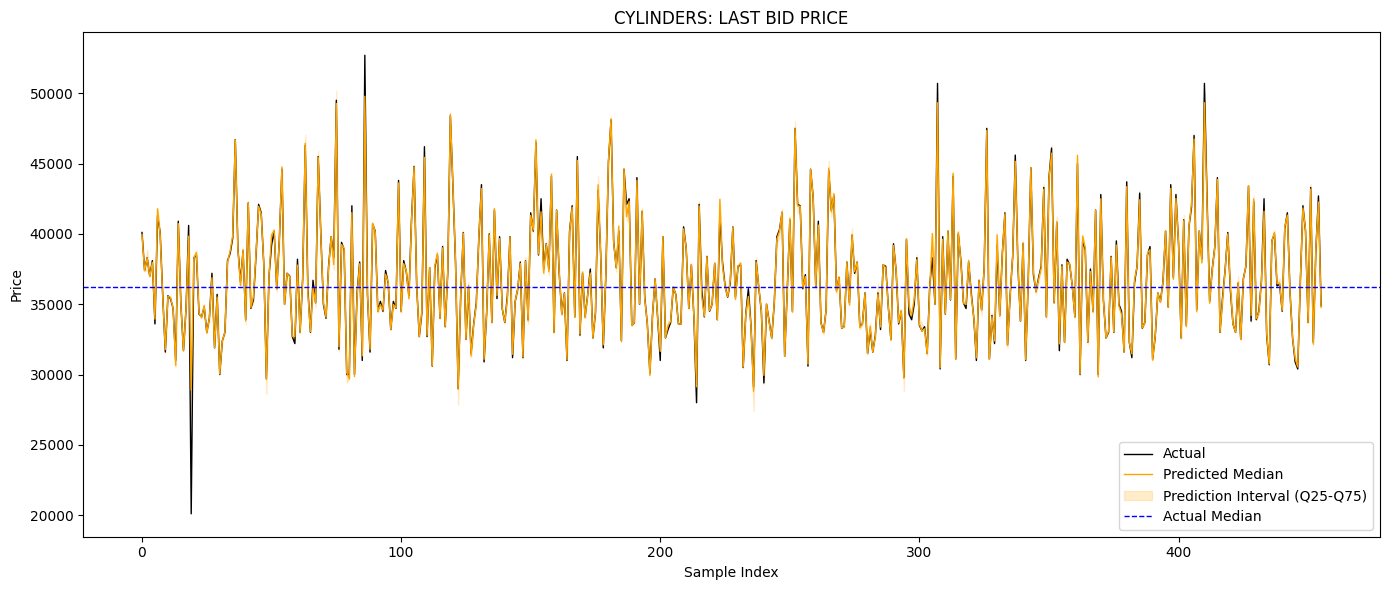

In [ ]:
# 1. Prepare data for cylinders
cyl_df = auction_df[auction_df['product_group'] == 'cylinders'].dropna().copy()
cyl_df['rp_per_qty'] = cyl_df['proposed_rp'] / cyl_df['quantity']
cyl_df['amt_per_qty'] = cyl_df['last_bid_price']
cyl_df['proposed_rp_clipped'] = cyl_df['proposed_rp'].clip(lower=0, upper=1_000_000)
cyl_df['quantity_clipped'] = cyl_df['quantity'].clip(lower=0, upper=1_000_000)
cyl_df['last_bid_price_clipped'] = cyl_df['last_bid_price'].clip(lower=0, upper=1_000_000)

features = [
    'month', 'year',
    'amt_per_qty',
    'quantity_clipped', 'proposed_rp_clipped'
]

from sklearn.model_selection import train_test_split
X = cyl_df[features]
y = cyl_df['last_bid_price']
    data_with_target = X.copy()
    data_with_target['target'] = y
    data_with_target['date'] = df['auction_date']
    # Split data
    X_train = train_data.drop(['target', 'date'], axis=1)
    X_test = test_data.drop(['target', 'date'], axis=1)
    y_train = train_data['target']
    y_test = test_data['target']

# 2. Train quantile models
model_q25_lbp = fit_lgb_quantile(X_train, y_train, 0.25)
model_q50_lbp = fit_lgb_quantile(X_train, y_train, 0.5)
model_q75_lbp = fit_lgb_quantile(X_train, y_train, 0.75)

# 3. Predict
pred_q25_lbp = model_q25_lbp.predict(X_test)
pred_q50_lbp = model_q50_lbp.predict(X_test)
pred_q75_lbp = model_q75_lbp.predict(X_test)

# 4. Store results in a unique DataFrame
results_cyl_lbp = X_test.copy()
results_cyl_lbp['actual'] = y_test
results_cyl_lbp['pred_q25'] = pred_q25_lbp
results_cyl_lbp['pred_q50'] = pred_q50_lbp
results_cyl_lbp['pred_q75'] = pred_q75_lbp
results_cyl_lbp['abs_error'] = abs(results_cyl_lbp['actual'] - results_cyl_lbp['pred_q50'])
results_cyl_lbp['pct_error'] = 100 * results_cyl_lbp['abs_error'] / results_cyl_lbp['actual']

# 5. Print and plot
print_ft_sample_predictions(results_cyl_lbp, title="SAMPLE PREDICTIONS - CYLINDERS: LAST BID PRICE")
plot_predictions(results_cyl_lbp, title="CYLINDERS: LAST BID PRICE")

In [54]:
auction_df.columns.tolist()

['year_month_dt',
 'product_group',
 'proposed_rp',
 'last_bid_price',
 'brass_index_poly',
 'ewm_last_bid_price',
 'ewm_proposed_rp',
 'quantity',
 'h1_buyer_name',
 'year',
 'month']

SAMPLE PREDICTIONS - VALVES: PROPOSED RP
 Actual Price  Predicted Price   Prediction Error   Error %   Lower Bound (Q25)   Upper Bound (Q75)    In Range
   454,333.33       443,315.23          11,018.10      2.43          432,839.10          447,419.44          No
   482,000.00       488,962.34           6,962.34      1.44          477,934.14          486,000.96         Yes
   416,666.67       445,808.86          29,142.19      6.99          442,664.85          453,888.61          No
   449,666.67       448,414.72           1,251.95      0.28          443,858.39          449,674.36         Yes
   467,000.00       467,176.26             176.26      0.04          468,142.82          463,834.93         Yes
   504,000.00       501,891.43           2,108.57      0.42          491,572.89          507,589.36         Yes
   488,000.00       493,865.24           5,865.24      1.20          490,250.60          495,201.69          No
   442,333.33       455,311.74          12,978.41      2.93    

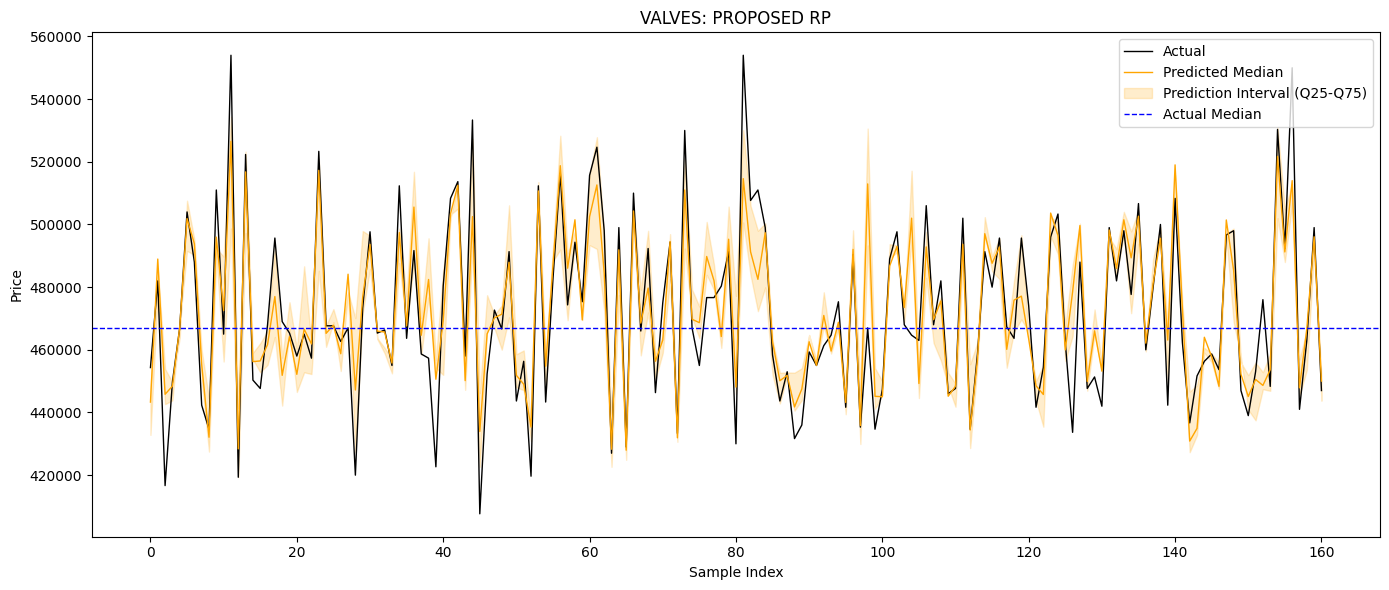

In [65]:

valve_df = auction_df[auction_df['product_group'] == 'valves'].dropna().copy()
valve_df['rp_per_qty'] = valve_df['proposed_rp'] / valve_df['quantity']
valve_df['amt_per_qty'] = valve_df['last_bid_price']
valve_df['proposed_rp_clipped'] = valve_df['proposed_rp'].clip(lower=0, upper=1_000_000)
valve_df['quantity_clipped'] = valve_df['quantity'].clip(lower=0, upper=1_000_000)
valve_df['last_bid_price_clipped'] = valve_df['last_bid_price'].clip(lower=0, upper=1_000_000)

features_valve = [
    'month', 'year',
    'rp_per_qty', 'amt_per_qty', 'quantity_clipped', 'last_bid_price_clipped',
    'brass_index_poly' 
]

from sklearn.model_selection import train_test_split
X_valve = valve_df[features_valve]
y_valve = valve_df['proposed_rp']
X_valve_train, X_valve_test, y_valve_train, y_valve_test = train_test_split(X_valve, y_valve, test_size=0.2, random_state=42)

# 2. Train quantile models
model_valve_q25 = fit_lgb_quantile(X_valve_train, y_valve_train, 0.25)
model_valve_q50 = fit_lgb_quantile(X_valve_train, y_valve_train, 0.5)
model_valve_q75 = fit_lgb_quantile(X_valve_train, y_valve_train, 0.75)

# 3. Predict
pred_valve_q25 = model_valve_q25.predict(X_valve_test)
pred_valve_q50 = model_valve_q50.predict(X_valve_test)
pred_valve_q75 = model_valve_q75.predict(X_valve_test)

# 4. Store results in a unique DataFrame
results_valve_rp = X_valve_test.copy()
results_valve_rp['actual'] = y_valve_test
results_valve_rp['pred_q25'] = pred_valve_q25
results_valve_rp['pred_q50'] = pred_valve_q50
results_valve_rp['pred_q75'] = pred_valve_q75
results_valve_rp['abs_error'] = abs(results_valve_rp['actual'] - results_valve_rp['pred_q50'])
results_valve_rp['pct_error'] = 100 * results_valve_rp['abs_error'] / results_valve_rp['actual']

# 5. Print and plot
print_ft_sample_predictions(results_valve_rp, title="SAMPLE PREDICTIONS - VALVES: PROPOSED RP")
plot_predictions(results_valve_rp, title="VALVES: PROPOSED RP")


SAMPLE PREDICTIONS - VALVES: LAST BID PRICE
 Actual Price  Predicted Price   Prediction Error   Error %   Lower Bound (Q25)   Upper Bound (Q75)    In Range
   445,000.00       445,230.15             230.15      0.05          445,095.90          445,770.30          No
   484,000.00       485,214.89           1,214.89      0.25          484,625.94          484,832.17          No
   418,000.00       419,710.51           1,710.51      0.41          419,027.28          420,652.80          No
   477,000.00       477,018.31              18.31      0.00          476,272.30          477,598.90         Yes
   536,000.00       528,973.34           7,026.66      1.31          525,027.58          532,562.93          No
   526,000.00       525,967.92              32.08      0.01          525,864.53          526,858.89         Yes
   516,000.00       516,831.86             831.86      0.16          514,930.98          518,858.03         Yes
   464,000.00       463,847.82             152.18      0.03 

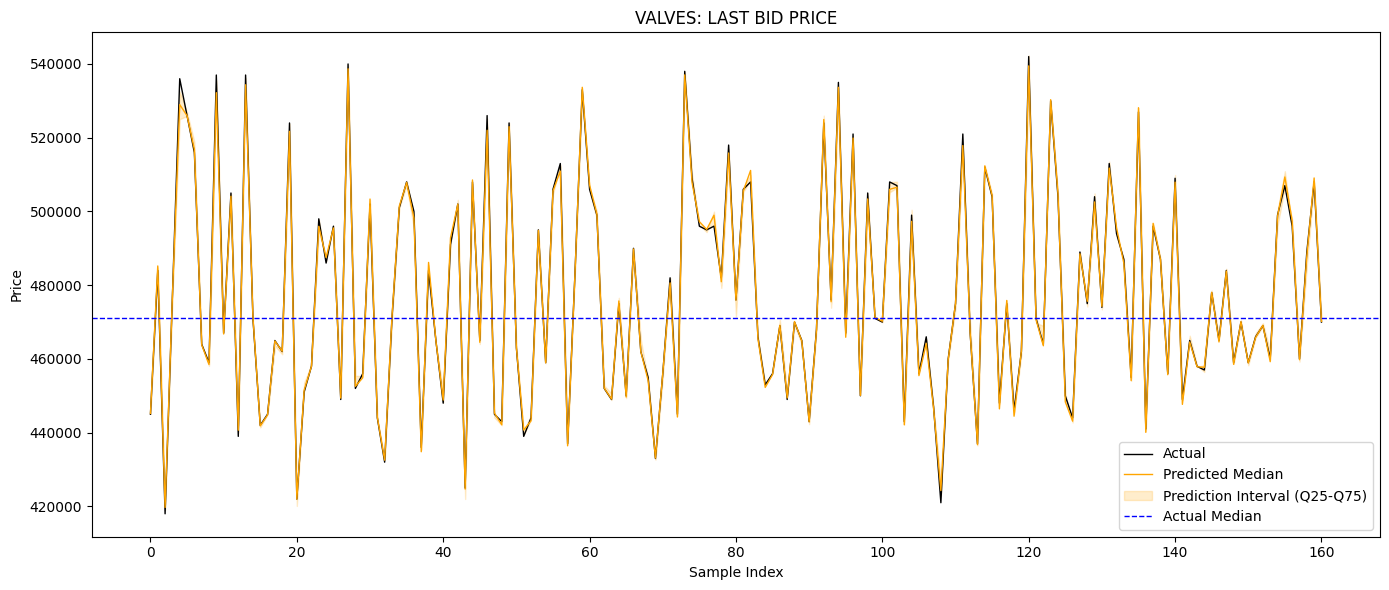

In [69]:

valve_df = auction_df[auction_df['product_group'] == 'valves'].dropna().copy()
valve_df['rp_per_qty'] = valve_df['proposed_rp'] / valve_df['quantity']
valve_df['amt_per_qty'] = valve_df['last_bid_price']
valve_df['proposed_rp_clipped'] = valve_df['proposed_rp'].clip(lower=0, upper=1_000_000)
valve_df['quantity_clipped'] = valve_df['quantity'].clip(lower=0, upper=1_000_000)
valve_df['last_bid_price_clipped'] = valve_df['last_bid_price'].clip(lower=0, upper=1_000_000)

features_valve = [
    'month', 'year',
    'rp_per_qty', 'amt_per_qty',
    'proposed_rp_clipped', 'quantity_clipped',
    'brass_index_poly' 
]

from sklearn.model_selection import train_test_split
X_valve = valve_df[features_valve]
y_valve = valve_df['last_bid_price']
X_valve_train, X_valve_test, y_valve_train, y_valve_test = train_test_split(X_valve, y_valve, test_size=0.2, random_state=42)

# 2. Train quantile models
model_valve_q25_lbp = fit_lgb_quantile(X_valve_train, y_valve_train, 0.25)
model_valve_q50_lbp = fit_lgb_quantile(X_valve_train, y_valve_train, 0.5)
model_valve_q75_lbp = fit_lgb_quantile(X_valve_train, y_valve_train, 0.75)

# 3. Predict
pred_valve_q25_lbp = model_valve_q25_lbp.predict(X_valve_test)
pred_valve_q50_lbp = model_valve_q50_lbp.predict(X_valve_test)
pred_valve_q75_lbp = model_valve_q75_lbp.predict(X_valve_test)

# 4. Store results in a unique DataFrame
results_valve_lbp = X_valve_test.copy()
results_valve_lbp['actual'] = y_valve_test
results_valve_lbp['pred_q25'] = pred_valve_q25_lbp
results_valve_lbp['pred_q50'] = pred_valve_q50_lbp
results_valve_lbp['pred_q75'] = pred_valve_q75_lbp
results_valve_lbp['abs_error'] = abs(results_valve_lbp['actual'] - results_valve_lbp['pred_q50'])
results_valve_lbp['pct_error'] = 100 * results_valve_lbp['abs_error'] / results_valve_lbp['actual']

# 5. Print and plot
print_ft_sample_predictions(results_valve_lbp, title="SAMPLE PREDICTIONS - VALVES: LAST BID PRICE")
plot_predictions(results_valve_lbp, title="VALVES: LAST BID PRICE")


#  SAVING FINETUNED MODELS

In [70]:


# Saving the CYLINDERS: PROPOSED RP models
joblib.dump(model_q25, '../models/cyl_proposed_rp_q25.joblib')
joblib.dump(model_q50, '../models/cyl_proposed_rp_q50.joblib')
joblib.dump(model_q75, '../models/cyl_proposed_rp_q75.joblib')

#Saving the CYLINDERS: LAST BID PRICE models
joblib.dump(model_q25_lbp, '../models/cyl_last_bid_price_q25.joblib')
joblib.dump(model_q50_lbp, '../models/cyl_last_bid_price_q50.joblib')
joblib.dump(model_q75_lbp, '../models/cyl_last_bid_price_q75.joblib')

# Saving the VALVES: PROPOSED RP models
joblib.dump(model_valve_q25, '../models/valve_proposed_rp_q25.joblib')
joblib.dump(model_valve_q50, '../models/valve_proposed_rp_q50.joblib')
joblib.dump(model_valve_q75, '../models/valve_proposed_rp_q75.joblib')

# Saving the VALVES: LAST BID PRICE models
joblib.dump(model_valve_q25_lbp, '../models/valve_last_bid_price_q25.joblib')
joblib.dump(model_valve_q50_lbp, '../models/valve_last_bid_price_q50.joblib')
joblib.dump(model_valve_q75_lbp, '../models/valve_last_bid_price_q75.joblib')


['../models/valve_last_bid_price_q75.joblib']